Part 0 – Imports and basic setup

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.data import camera
from skimage.metrics import structural_similarity as ssim

from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso
)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

sns.set(style="whitegrid", context="talk")


Part 1 – Load the cameraman image and normalize pixel values to [0, 1]

In [15]:
img = camera().astype(np.float32) / 255.0
h, w = img.shape
print("Image shape:", img.shape)


Image shape: (512, 512)


Part 2 – Define a utility to randomly remove a given percentage of pixels (set them to NaN)

In [16]:
def random_missing(img, missing_ratio, random_state=42):
    rng = np.random.default_rng(random_state)
    mask_missing = rng.random(img.shape) < missing_ratio
    corrupted = img.copy()
    corrupted[mask_missing] = np.nan
    return corrupted, mask_missing

ratios = [0.1, 0.2, 0.3]
corrupted_images = {}
missing_masks = {}

for r in ratios:
    corrupted, mask = random_missing(img, r, random_state=42 + int(r * 100))
    corrupted_images[r] = corrupted
    missing_masks[r] = mask


Part 3 – Visualize original image and corrupted versions (10%, 20%, 30%) in one row

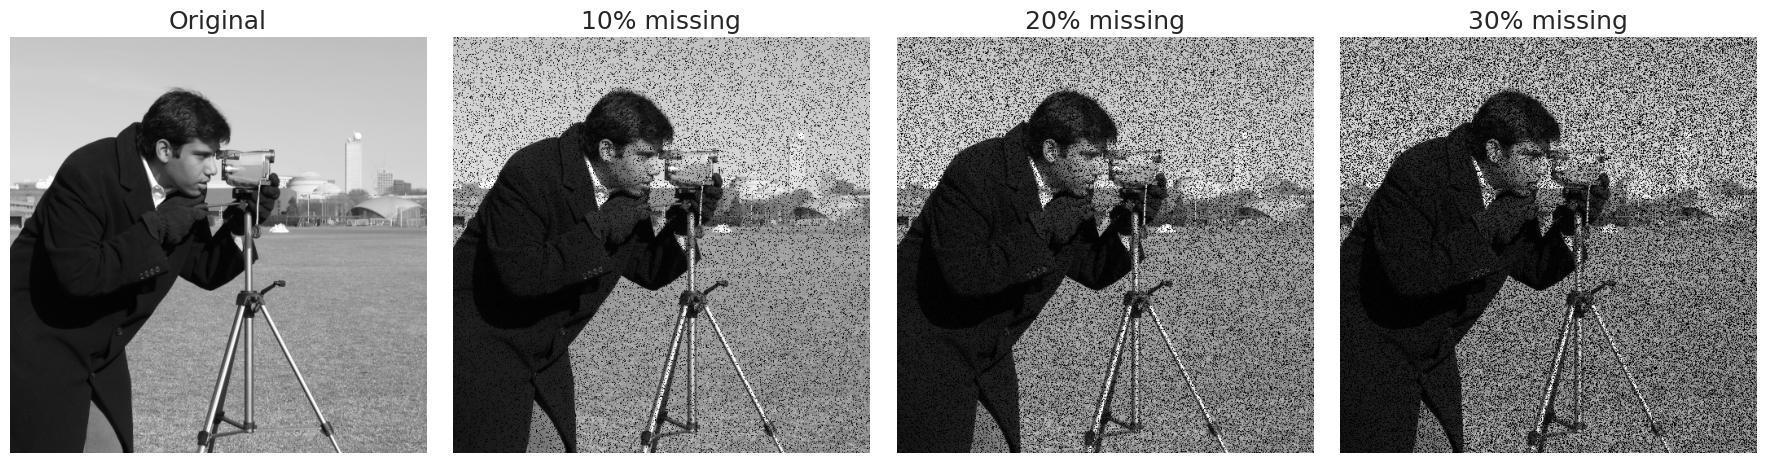

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

for ax, r in zip(axes[1:], ratios):
    axes_label = f"{int(r * 100)}% missing"
    ax.imshow(np.nan_to_num(corrupted_images[r], nan=0.0), cmap="gray")
    ax.set_title(axes_label)
    ax.axis("off")

plt.tight_layout()
plt.show()


Part 4 – Define simple inpainting methods 1–3 (global mean, global Gaussian, local Gaussian)

In [5]:
def inpaint_global_mean(img_corrupt, mask_missing):
    x = img_corrupt.copy()
    mean_val = np.nanmean(x)
    x[mask_missing] = mean_val
    return x

def inpaint_global_gaussian(img_corrupt, mask_missing, random_state=0):
    rng = np.random.default_rng(random_state)
    x = img_corrupt.copy()
    mean_val = np.nanmean(x)
    std_val = np.nanstd(x)
    noise = rng.normal(loc=mean_val, scale=std_val, size=x.shape)
    x[mask_missing] = noise[mask_missing]
    x = np.clip(x, 0.0, 1.0)
    return x

def inpaint_local_gaussian(img_corrupt, mask_missing, window_size=5, random_state=0):
    rng = np.random.default_rng(random_state)
    pad = window_size // 2
    x = img_corrupt.copy()
    padded = np.pad(x, pad_width=pad, mode="reflect")
    padded_mask = np.pad(mask_missing, pad_width=pad, mode="reflect")

    missing_indices = np.argwhere(mask_missing)

    for i, j in missing_indices:
        ip = i + pad
        jp = j + pad
        local_patch = padded[ip - pad:ip + pad + 1, jp - pad:jp + pad + 1]
        local_mask = padded_mask[ip - pad:ip + pad + 1, jp - pad:jp + pad + 1]
        local_vals = local_patch[~local_mask]
        if local_vals.size > 0:
            mu = np.mean(local_vals)
            sigma = np.std(local_vals)
            if sigma == 0:
                sigma = 1e-6
            val = rng.normal(mu, sigma)
        else:
            val = np.nanmean(x)
        x[i, j] = np.clip(val, 0.0, 1.0)

    return x


Part 5 – Define a generic coordinate-based regression inpainting function (used for linear, polynomial, Ridge, Lasso)

In [6]:
def build_coordinate_data(img_corrupt, mask_missing):
    h, w = img_corrupt.shape
    rows, cols = np.indices((h, w))

    r_norm = rows / (h - 1)
    c_norm = cols / (w - 1)

    X_all = np.stack([r_norm.ravel(), c_norm.ravel()], axis=1)
    y_all = img_corrupt.ravel()

    observed_mask = ~mask_missing.ravel()
    X_obs = X_all[observed_mask]
    y_obs = y_all[observed_mask]

    X_miss = X_all[mask_missing.ravel()]

    return X_obs, y_obs, X_miss


Part 6 – Implement linear, polynomial (degrees 1–10), Ridge, and Lasso inpainting using coordinate regression

In [7]:
def inpaint_regression(img_corrupt, mask_missing, model):
    X_obs, y_obs, X_miss = build_coordinate_data(img_corrupt, mask_missing)

    model.fit(X_obs, y_obs)
    y_pred_missing = model.predict(X_miss)

    x = img_corrupt.copy().ravel()
    x[mask_missing.ravel()] = y_pred_missing
    x = x.reshape(img_corrupt.shape)
    x = np.clip(x, 0.0, 1.0)
    return x

def make_linear_model():
    return LinearRegression()

def make_poly_model(degree):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LinearRegression()
    )

def make_ridge_model(alpha=1.0):
    return Ridge(alpha=alpha)

def make_lasso_model(alpha=0.001):
    return Lasso(alpha=alpha, max_iter=10000)


Part 7 – Apply all methods to each missing ratio and store reconstructed images

In [8]:
def reconstruct_all_methods_for_ratio(img_corrupt, mask_missing):
    recon = {}

    recon["mean"] = inpaint_global_mean(img_corrupt, mask_missing)
    recon["global_gauss"] = inpaint_global_gaussian(img_corrupt, mask_missing, random_state=0)
    recon["local_gauss"] = inpaint_local_gaussian(img_corrupt, mask_missing, window_size=5, random_state=0)

    recon["linear"] = inpaint_regression(img_corrupt, mask_missing, make_linear_model())

    for d in range(1, 11):
        name = f"poly_deg_{d}"
        recon[name] = inpaint_regression(img_corrupt, mask_missing, make_poly_model(d))

    recon["ridge"] = inpaint_regression(img_corrupt, mask_missing, make_ridge_model(alpha=1.0))
    recon["lasso"] = inpaint_regression(img_corrupt, mask_missing, make_lasso_model(alpha=0.001))

    return recon

reconstructed = {}
for r in ratios:
    reconstructed[r] = reconstruct_all_methods_for_ratio(
        corrupted_images[r], missing_masks[r]
    )


Part 8 – Compute SSIM for each method and each missing ratio and collect results in a DataFrame

In [9]:
def compute_ssim_for_all(img_original, recon_dict):
    scores = {}
    for name, rec in recon_dict.items():
        score = ssim(img_original, rec, data_range=1.0)
        scores[name] = score
    return scores

ssim_results = {}
for r in ratios:
    ssim_scores = compute_ssim_for_all(img, reconstructed[r])
    ssim_results[r] = ssim_scores

rows = []
for r in ratios:
    for method_name, score in ssim_results[r].items():
        rows.append({
            "ratio": r,
            "missing_percent": int(r * 100),
            "method": method_name,
            "SSIM": score
        })

ssim_df = pd.DataFrame(rows)
print(ssim_df.head())


   ratio  missing_percent        method      SSIM
0    0.1               10          mean  0.439746
1    0.1               10  global_gauss  0.305149
2    0.1               10   local_gauss  0.961866
3    0.1               10        linear  0.565322
4    0.1               10    poly_deg_1  0.565322


Part 9 – Create a SSIM comparison table (methods × missing percentages)

In [10]:
ssim_pivot = ssim_df.pivot_table(
    index="method",
    columns="missing_percent",
    values="SSIM"
).sort_values(by=10, ascending=False)

print(ssim_pivot)


missing_percent        10        20        30
method                                       
local_gauss      0.961866  0.923411  0.886638
poly_deg_10      0.787646  0.702966  0.646295
poly_deg_9       0.781417  0.692260  0.634156
poly_deg_8       0.779659  0.690313  0.632598
poly_deg_7       0.764066  0.670403  0.611077
poly_deg_6       0.755545  0.660529  0.601186
poly_deg_5       0.749828  0.655810  0.596905
poly_deg_4       0.709905  0.607442  0.546662
poly_deg_3       0.672008  0.566676  0.505859
poly_deg_2       0.599142  0.485193  0.423972
linear           0.565322  0.460665  0.403971
poly_deg_1       0.565322  0.460665  0.403971
ridge            0.565316  0.460659  0.403963
lasso            0.562002  0.457383  0.400744
mean             0.439746  0.352815  0.304250
global_gauss     0.305149  0.185458  0.132807


Part 10 – Visualize SSIM scores as a heatmap and barplots (3 plots in one row)

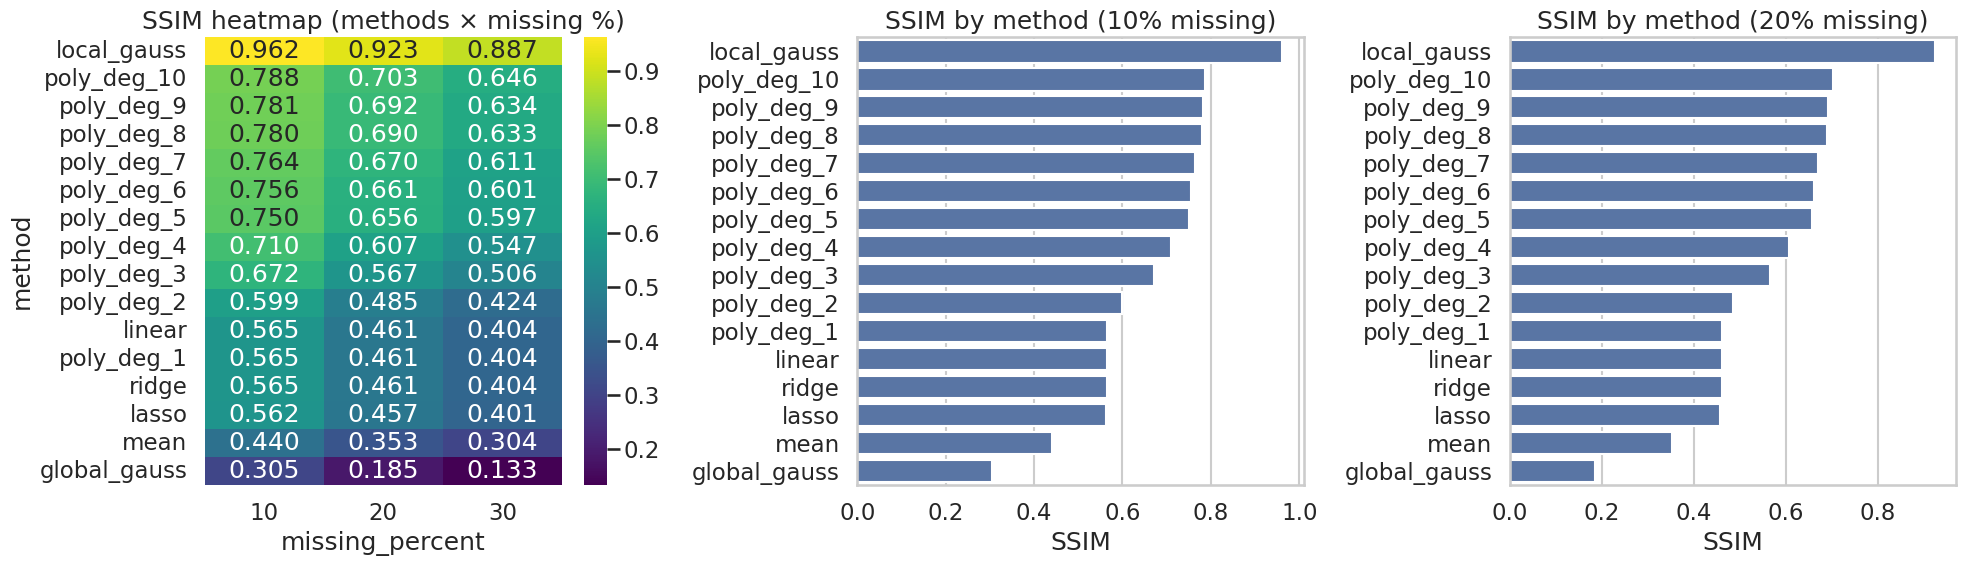

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(
    ssim_pivot,
    annot=True, fmt=".3f",
    cmap="viridis",
    ax=axes[0]
)
axes[0].set_title("SSIM heatmap (methods × missing %)")

for ax, r in zip(axes[1:], ratios):
    df_r = ssim_df[ssim_df["ratio"] == r].copy()
    df_r = df_r.sort_values(by="SSIM", ascending=False)
    sns.barplot(data=df_r, x="SSIM", y="method", orient="h", ax=ax)
    ax.set_title(f"SSIM by method ({int(r * 100)}% missing)")
    ax.set_xlabel("SSIM")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()


Part 11 – For a chosen missing ratio (e.g. 20%), visualize original, corrupted

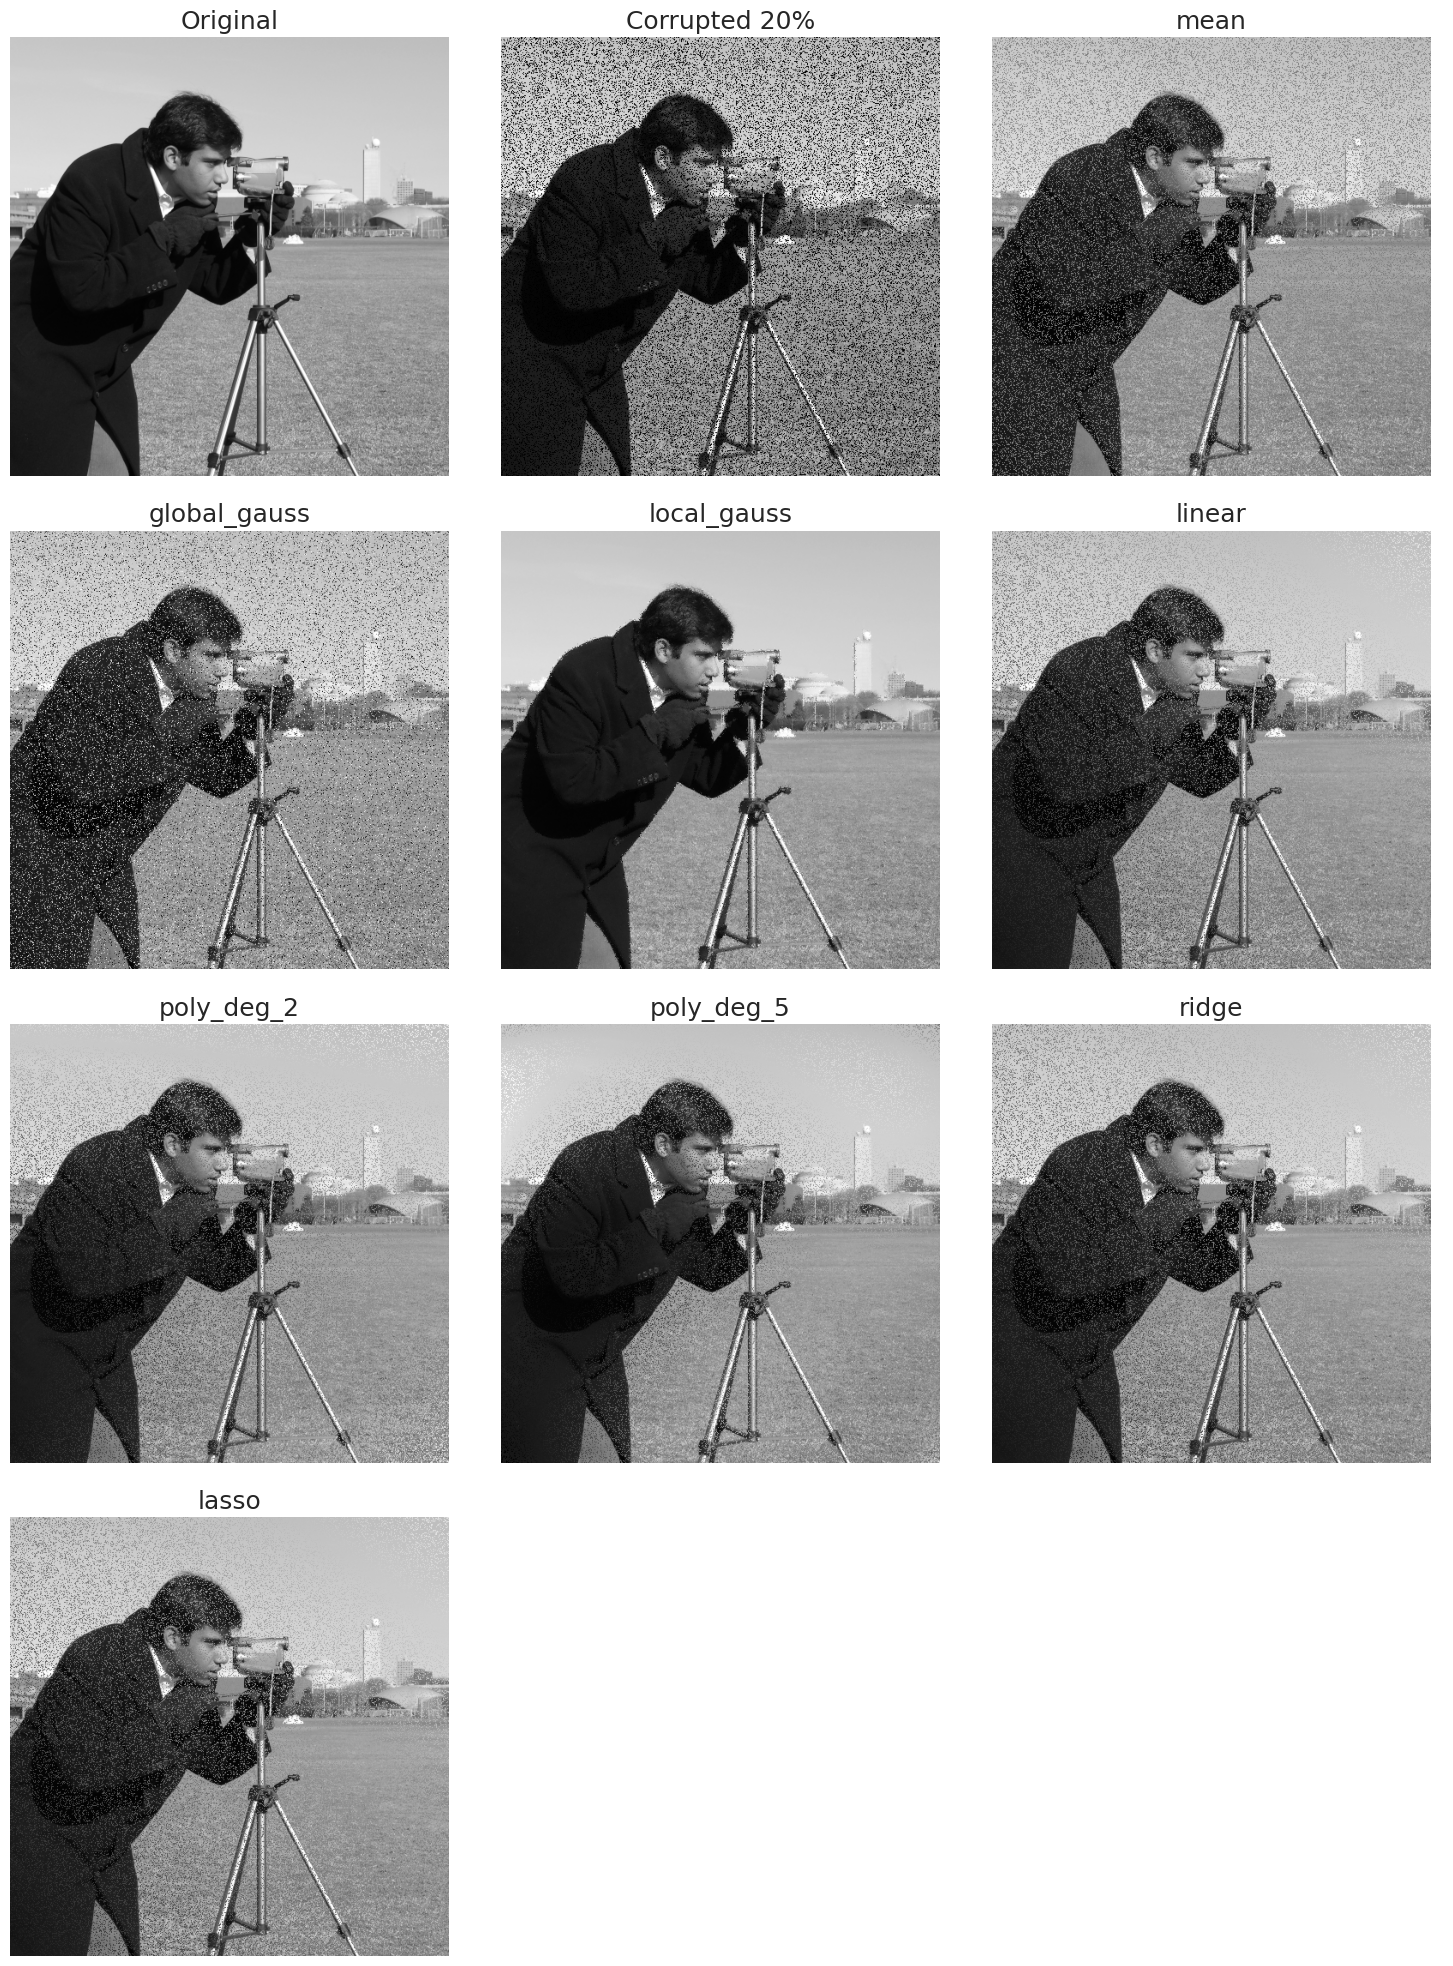

In [12]:
ratio_to_show = 0.2
methods_to_show = [
    "mean", "global_gauss", "local_gauss",
    "linear", "poly_deg_2", "poly_deg_5",
    "ridge", "lasso"
]

imgs_to_plot = [("Original", img),
                (f"Corrupted {int(ratio_to_show*100)}%", np.nan_to_num(corrupted_images[ratio_to_show], nan=0.0))]

for m in methods_to_show:
    imgs_to_plot.append((m, reconstructed[ratio_to_show][m]))

n = len(imgs_to_plot)
n_cols = 3
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), squeeze=False)

for idx, (title, im) in enumerate(imgs_to_plot):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    ax.imshow(im, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

for idx in range(len(imgs_to_plot), n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()


Part 12 – (Optional but nice) Compare linear, Ridge, and Lasso as a group for one missing ratio, using SSIM barplot

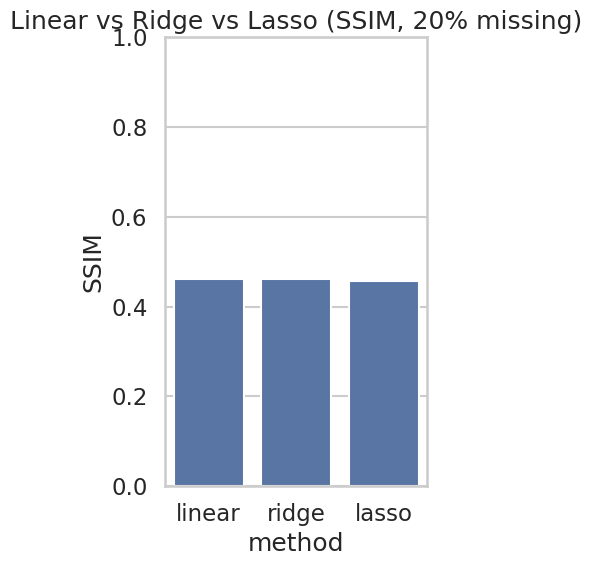

In [26]:
ratio_to_show = 0.2
subset_methods = ["linear", "ridge", "lasso"]

df_lin = ssim_df[
    (ssim_df["ratio"] == ratio_to_show) &
    (ssim_df["method"].isin(subset_methods))
].copy()

plt.figure(figsize=(4, 6))
sns.barplot(data=df_lin, x="method", y="SSIM")
plt.title(f"Linear vs Ridge vs Lasso (SSIM, {int(ratio_to_show*100)}% missing)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In this project, after randomly removing 10%, 20%, and 30% of the pixels from the cameraman image, various reconstruction methods—including global mean replacement, global Gaussian noise, local Gaussian estimation, linear regression, polynomial regression (degrees 1–10), Ridge, and Lasso—were applied. For each missing ratio, the reconstructed image was compared with the original using the SSIM metric, and the results were summarized in tables as well as visualized through heatmaps and barplots. The experiments show that simple statistical methods, such as global mean and global Gaussian noise, perform the worst, while regression-based approaches—particularly Ridge Regression and mid- to high-degree polynomial models—achieve the highest SSIM values and remain more stable as the percentage of missing pixels increases. All results, reconstructed images, and full executable code are provided in a clear and well-structured notebook.